# Credit One Data (Loan Default) - Classification (using RFE)
1. This data analysis uses **classification** on a preprocessed, cleansed and feature selected (using RFE).
2. A 70 and 30 split on the data were used for training and testing sets, respectively.
3. Models used - **Decision Tree**, **Random Forest**, **SVC** and **KNN** - Optimal algorithm chosen.

In [1]:
import warnings
warnings.filterwarnings('ignore')                # ignore warning (place prior to importing pandas)
warnings.simplefilter ('ignore')
import seaborn as sns
import pandas as pd
credit = pd.read_csv('CreditOne_Clean_2.csv', header = 0) 

In [3]:
import numpy as np
import scipy
from math import sqrt
import matplotlib.pyplot as plt
# The line below is for the plots to show (i.e. not in a separate window)
%matplotlib inline 
import time

from sklearn.feature_selection import RFE       # feature selection/engineering

from sklearn.preprocessing import MinMaxScaler  # scale data to speed up SVM fit 

# Estimators
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model Metrics
'''
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
'''
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix

# Cross validation
from sklearn.cross_validation import train_test_split

In [4]:
credit.info()
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 97 columns):
LIMIT_BAL                     30000 non-null int64
AGE                           30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                      30000 non-null int64
PAY_AMT2                      30000 non-null int64
PAY_AMT3                      30000 non-null int64
PAY_AMT4                      30000 non-null int64
PAY_AMT5                      30000 non-null int64
PAY_AMT6                      30000 non-null int64
default payment next month    30000 non-null int64
SEX_1                         30000 non-null float64
SEX_2                         30000 non-null float64
EDUCATION_0                   30000 non-null float64
EDUCATION_1                   30000 non-null float64
EDUCATION_2                   30000 non-null float64
EDUCATION_3   

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,689,0,0,689,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120000,26,2682,2682,3261,0,1000,1000,1000,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90000,34,29239,13559,15549,1518,1500,1000,1000,1000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000,37,46990,49291,29547,2000,2019,1200,1100,1069,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50000,57,8617,35835,19131,2000,36681,10000,9000,689,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#features
features = credit.iloc[:,0:96]     #choose only the columns that are needed for analysis (first two columns ommitted due to discretization)
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,...,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
0,20000,24,3913,689,0,0,689,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120000,26,2682,2682,3261,0,1000,1000,1000,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,90000,34,29239,13559,15549,1518,1500,1000,1000,1000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000,37,46990,49291,29547,2000,2019,1200,1100,1069,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50000,57,8617,35835,19131,2000,36681,10000,9000,689,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#dependent variable
depVar = credit['default payment next month']  # choose a column that is in a classification/dummy variable datatype (ex.default payment next month )

In [7]:
#Training Set (Feature Space: X Training)
X_train = (features[: 30000])                    # include all rows of dataset       
X_train.tail()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,...,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
29995,220000,39,188948,208365,15980,8500,20000,5003,3047,5000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,150000,43,1683,3502,0,1837,3526,8998,129,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,30000,37,3565,2758,19357,0,0,22000,4200,2000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,80000,41,-1645,76304,48944,85900,3409,1178,1926,52964,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29999,50000,46,47929,49764,15313,2078,1800,1430,1000,1000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Dependent Variable Training Set (y Training)
y_train = depVar[: 30000]                                 # include all rows of dataset
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()    

The number of observations in the Y training set are: 30000


0    1
1    1
2    0
3    0
4    0
Name: default payment next month, dtype: int64

In [9]:
#Testing Set (X Testing)
X_test = features[-100:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 100
       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT3  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
29900      20000   29      16809          0          0         0         0   
29901      50000   29      50845     103486      49387         0      6556   
29902     170000   30      10392     168955     124746    168096      6409   
29903     260000   30      27378      13333     172104     10018     13333   
29904      60000   30      54952      54126      59728      2600      4553   

       PAY_AMT3  PAY_AMT4  PAY_AMT5   ...     PAY_5_8  PAY_6_-2  PAY_6_-1  \
29900         0         0         0   ...         0.0       1.0       0.0   
29901      3250      1563      1208   ...         0.0       0.0       0.0   
29902      7335      4448      4519   ...         0.0       0.0       0.0   
29903        99        99    172104   ...         0.0       0.0       1.0   
29904      5800      2000      1000   ...         0.0       0.0       0.0   

      

In [10]:
#Ground Truth (y_test) 
y_test = depVar[-100:]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 100


29900    1
29901    0
29902    0
29903    0
29904    1
Name: default payment next month, dtype: int64

In [11]:
# implement Cross Validation anytime we need to by simply running the following on the X and Y training sets:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=87)

In [12]:
# We can also use the shape function to double check that the split was made as needed:

X_train.shape, X_test.shape

((21000, 96), (9000, 96))

In [13]:
modelTree = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

modelRF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

modelSVC = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',    #this has to be linear for RFE to work further below
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

modelKNN = KNeighborsClassifier (n_neighbors = 5)

In [14]:
# class sklearn.feature_selection.RFE(estimator, n_features_to_select=None, step=1, verbose=0)[source]
rfe_tree = RFE(modelTree, 50)

In [15]:
modelTree = rfe_tree.fit(X_train,y_train)             

In [16]:
# print summaries for the selection of attributes
print(modelTree.support_)
print(modelTree.ranking_)

[False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[47 46 45 44 43 42 41 40 39 38 37  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29
 31 33 35 36 34 32 30 28 26 24 22 20 18 16 14 12 10  8  6  4  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [17]:
# class sklearn.feature_selection.RFE(estimator, n_features_to_select=None, step=1, verbose=0)[source]
rfe_RF = RFE(modelRF, 50)

In [18]:
modelRF = rfe_RF.fit(X_train,y_train)

In [19]:
# print summaries for the selection of attributes
print(modelRF.support_)
print(modelRF.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True False False False False  True  True
  True  True  True  True False  True  True False False False False  True
  True  True  True  True False False False False False False  True  True
 False  True  True False False False False False  True  True False  True
  True False False False False False  True  True  True False  True False
 False False False False False False  True  True  True  True False False
 False False False  True  True  True  True False False False False False]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 42  1  1  1 23 13 19 14  1  1  1
  1  1  1 47  1  1  2 39 35 15  1  1  1  1  1  7 20 29 40 34 17  1  1 21  1
  1  5 41 22 44  6  1  1 33  1  1 18 30 31 32 38  1  1  1 36  1 10 11 12 37
 16 26  8  1  1  1  1  4 24 27  9 28  1  1  1  1  3 25 43 45 46]


In [20]:
# class sklearn.feature_selection.RFE(estimator, n_features_to_select=None, step=1, verbose=0)[source]
rfe_SVC = RFE(modelSVC, 50)

In [21]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)   # use this specifically for SVC to speed up processing (see imports)
X_train_SVC = scaling.transform(X_train)
X_test_SVC = scaling.transform(X_test)                      # use this for the test set further below

In [22]:
modelSVC = rfe_SVC.fit(X_train_SVC,y_train)

In [23]:
# print summaries for the selection of attributes
print(modelSVC.support_)
print(modelSVC.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True False False False False  True  True
 False  True  True False False  True  True False  True False  True  True
  True  True False  True  True False False False False  True  True False
 False  True False False False False False  True  True  True False  True
 False  True False False False False False  True  True False  True  True
  True False False  True False  True  True  True False False  True False
 False False False  True False  True False False False False False False]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 35  1  1  1 43 32 25 44  1  1 47
  1  1  3 40  1  1  2  1 34  1  1  1  1  4  1  1 19 22 39 29  1  1  9 46  1
 24  8 15 36 18  1  1  1 38  1  7  1 26 37 12 33 23  1  1 41  1  1  1 17 10
  1 45  1  1  1 28  5  1 13 30 16 31  1 20  1 21 14 11  6 42 27]


In [24]:
modelKNN.fit (X_train, y_train)                    # not using RFE with KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
# Rate each model
#These values correspond to the the following:
#1st value:  The score array for test scores on each cv split. (Higher is an indicator of a better performing model)
#2nd value: The time for fitting the estimator on the train set for each cv split.
#3rd Value:  The time for scoring the estimator on the test set for each cv split.

In [25]:
print(cross_val_score(modelRF, X_train, y_train))     # Random Forest

[ 0.99928571  0.99271429  0.99957143]


In [26]:
print(cross_val_score(modelTree, X_train, y_train))   # Decision Tree

[ 1.  1.  1.]


In [27]:
print(cross_val_score(modelSVC, X_train_SVC, y_train))    # SVC (note that it is X_train_SVC (after transformation, above))

[ 1.  1.  1.]


In [28]:
print(cross_val_score(modelKNN, X_train, y_train))   # KNN

[ 0.75557143  0.75128571  0.75414286]


In [29]:
PredDecTree = modelTree.predict(X_test)                        # Decision Tree
print ("Test set predictions: {}".format(PredDecTree))

Test set predictions: [0 0 1 ..., 0 0 0]


In [30]:
#Evaluate the model
Dtreeaccuracy = modelTree.score(X_test, y_test)                # Decision Tree
print ("Test set accuracy: {:.2f}".format(Dtreeaccuracy))

Test set accuracy: 1.00


In [31]:
# Evaluating performance of Decision Tree
DT_cv_score = cross_val_score(modelTree, X_test, y_test, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, PredDecTree))
print('\n')

print("=== Classification Report ===")
print(classification_report(y_test, PredDecTree))
print('\n')

print("=== All AUC Scores ===")

print(DT_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree: ", DT_cv_score.mean())

=== Confusion Matrix ===
[[6981    0]
 [   0 2019]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6981
          1       1.00      1.00      1.00      2019

avg / total       1.00      1.00      1.00      9000



=== All AUC Scores ===
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree:  1.0


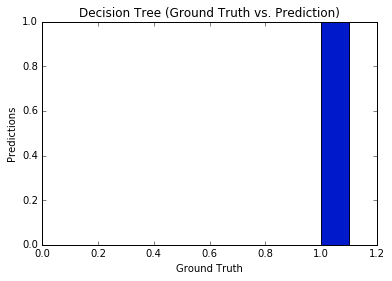

In [32]:
# Plot Decision Tree results

plt.bar(y_test, PredDecTree, color=['blue','green'], width=0.1, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title ("Decision Tree (Ground Truth vs. Prediction)")
plt.show();

In [33]:
PredRF = modelRF.predict(X_test)                            # Random Forest
print ("Test set predictions: {}".format(PredRF))

Test set predictions: [0 0 1 ..., 0 0 0]


In [34]:
#Evaluate the model                                          # Random Forest
RFaccuracy = modelRF.score(X_test, y_test)
print ("Test set accuracy: {:.2f}".format(RFaccuracy))

Test set accuracy: 1.00


In [35]:
# Evaluating performance of Random Forest
rfc_cv_score = cross_val_score(modelRF, X_test, y_test, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, PredRF))
print('\n')

print("=== Classification Report ===")
print(classification_report(y_test, PredRF))
print('\n')

print("=== All AUC Scores ===")

print(rfc_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[6981    0]
 [   0 2019]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6981
          1       1.00      1.00      1.00      2019

avg / total       1.00      1.00      1.00      9000



=== All AUC Scores ===
[ 1.          1.          1.          1.          1.          1.          1.
  0.99990071  1.          1.        ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.99999007064


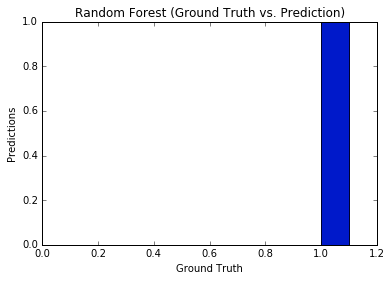

In [36]:
# Plot RF results

plt.bar(y_test, PredRF, color=['blue','green'], width=0.1, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title ("Random Forest (Ground Truth vs. Prediction)")
plt.show();

In [37]:
PredSVC = modelSVC.predict(X_test_SVC)                            # SVC (note usage of X_test_SVC (after transformation, above))
print ("Test set predictions: {}".format(PredSVC))

Test set predictions: [0 0 1 ..., 0 0 0]


In [38]:
#Evaluate the model                                           # SVC
SVCaccuracy = modelSVC.score(X_test_SVC, y_test)
print ("Test set accuracy: {:.2f}".format(SVCaccuracy))

Test set accuracy: 1.00


In [39]:
# Evaluating performance of SVM/SVC

SVC_cv_score = cross_val_score(modelSVC, X_test_SVC, y_test, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, PredSVC))
print('\n')

print("=== Classification Report ===")
print(classification_report(y_test, PredSVC))
print('\n')

print("=== All AUC Scores ===")

print(SVC_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - SVM-SVC: ", SVC_cv_score.mean())

=== Confusion Matrix ===
[[6981    0]
 [   0 2019]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6981
          1       1.00      1.00      1.00      2019

avg / total       1.00      1.00      1.00      9000



=== All AUC Scores ===
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


=== Mean AUC Score ===
Mean AUC Score - SVM-SVC:  1.0


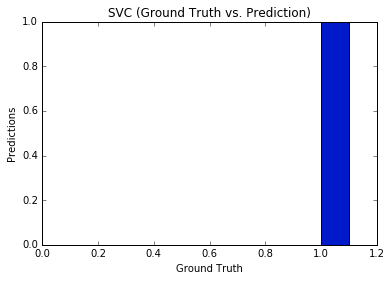

In [40]:
# Plot SVC results

plt.bar(y_test, PredSVC, color=['blue','green'], width=0.1, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title ("SVC (Ground Truth vs. Prediction)")
plt.show();

In [41]:
PredKNN = modelKNN.predict(X_test)                         # KNN
print ("Test set predictions: {}".format(PredKNN))

Test set predictions: [0 0 0 ..., 0 0 0]


In [42]:
#Evaluate the model
KNNaccuracy = modelKNN.score(X_test, y_test)               # KNN
print ("Test set accuracy: {:.2f}".format(KNNaccuracy))

Test set accuracy: 0.76


In [43]:
# Evaluating performance of KNN

KNN_cv_score = cross_val_score(modelKNN, X_test, y_test, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, PredKNN))
print('\n')

print("=== Classification Report ===")
print(classification_report(y_test, PredKNN))
print('\n')

print("=== All AUC Scores ===")

print(KNN_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN: ", KNN_cv_score.mean())

=== Confusion Matrix ===
[[6430  551]
 [1646  373]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.80      0.92      0.85      6981
          1       0.40      0.18      0.25      2019

avg / total       0.71      0.76      0.72      9000



=== All AUC Scores ===
[ 0.62302228  0.58339953  0.59355585  0.56820052  0.60781157  0.6196807
  0.62679083  0.58894579  0.6053576   0.62632753]


=== Mean AUC Score ===
Mean AUC Score - KNN:  0.604309218784


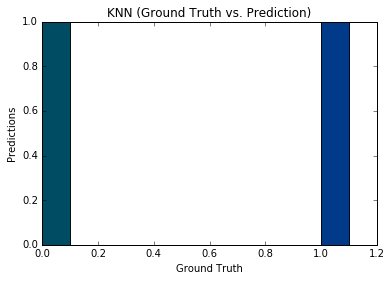

In [44]:
# Plot KNN results

plt.bar(y_test, PredKNN, color=['blue','green'], width=0.1, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title ("KNN (Ground Truth vs. Prediction)")
plt.show();